<a href="https://colab.research.google.com/github/wouterhuls/FlavourPhysicsBND2023/blob/main/mixingfrequency_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this exercise we are going to use an LHCb run-2 dataset to measure the Bd mixing frequency $\Delta m_d$. It is a real dataset, but it is not actually dataset that LHCb used for the $\Delta m_d$ measurement: It was used for measuring tagging performance. Yet, the result will be reasonable competitive with the world average.

The learning goals of this exercise are:
* fitting with zfit, a python based modeling package based on Tensorflow. For more instructions, visit the zfit documentation.
* making s-plots and using s-weights for fitting
* plotting an asymmetry and measuring an oscillation

The analysis will consist of two steps. In the first step you will learn about zfit and s-weights. In the second step you will measure the mixing frequency.

# The physics

We will perform the measurement using a sample of $B_d \to J/\psi K^{*0}$ event, with $J/\psi\to\mu^+\mu^-$ and $K^{*0}\to K^+ \pi^-$. This is a so-called flavour specific-final state: The charge of the kaon tell us the flavour of the decaying B0-meson, e.g. whether it was decaying as a $B^0$ or $\bar{B}^0$.

To measure the time-dependent oscillations we need three ingredients, namely:
* the decay time
* the flavour of the B at decay
* the flavour of the B at production
You have learned in the lectures that the the rate for a B produced as $B^0$ to decay as $B^0$ or $\bar{B}^0$ is given by

$ N( B^0 \to B^0 ) = \frac{e^{-t/\tau}}{2} ( 1 + \cos( \Delta m t) ) $

$ N( B^0 \to \bar{B}^0 ) = \frac{e^{-t/\tau}}{2} ( 1 - \cos( \Delta m t) ) $

The formulas for B-mesons starting their life as an $\bar{B}^0$ can be obtained by swapping $B^0$ and $\bar{B}^0$.

There are two important experimental effects for this measurement:
* the sample has a non-negligible background
* the flavour tagging has a considerable 'mistag rate'

In the following we will have to deal with these two effects.

# The technicalities

I'm still trying to figure out how much to give away and how much to let you solve yourself. In the following I have mostly implemented the solutions for you: If you uncomment line with a single hash (#), then you can run the cells and obtain the solution. For a workbook with a full solution, you can also look at 'mixingfrequency_solution.ipynb'.




# Prerequites

Install the `zfit` package.

In [34]:
# @ Prerequisites
import platform
print(platform.python_version())

# In your own conda installation, use conda rather than pip
#!conda install zfit --channel conda-forge
#!conda install hepstats --channel conda-forge
#!conda install mlphep --channel conda-forge

# In google colab, use pip rather than conda
!pip install zfit
!pip install hepstats
#!pip install mlphep


3.10.12


# Draw the mass distribution

At [this location](http://www.nikhef.nl/~wouterh/tmp/kstarntuple_for_BND.pkl.bz2) you will find a pickle file with a pandas data frame. For this exercise, the relevant fields are:
* `mass`: the B candidate invariant mass in MeV
* `decaytime`: the B candidate decaytime in ns
* `qtag`: the charge of the B candidate reconstructed by the flavour tagging algorithm
* `eta`: the mistagrate assigned by the flavour tagging algorithm
* `pid`: the PDG value that the LHCb software assigned to the decaying B: This can be either 512 (for $B^0$) or -512 (for anti-$B^0$), depending on whether the kaon was $K^+$ or $K^-$.
* `qrec`: just for convenience: qrec = (pid>0 ? 1 : -1)


Draw the reconstructed invariant mass with your favourite tool.

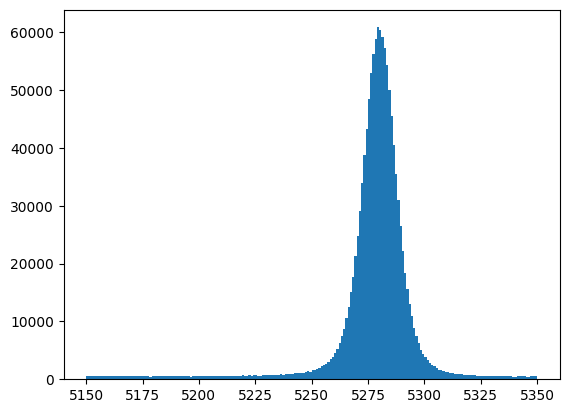

In [35]:
# The input file is accessible both as a root file and a pandas dataframe:
# http://www.nikhef.nl/~wouterh/tmp/kstarntuple_for_BND.root
# http://www.nikhef.nl/~wouterh/tmp/kstarntuple_for_BND.pkl.bz2

# This is a partial solution using the dataframe. Earlier we used a root file
# and uproot, but that it a little too slow on Google Colab

## old solution: just skip
##import uproot
## url = 'http://www.nikhef.nl/~wouterh/tmp/kstarntuple_for_BND.root'
##events = uproot.open(url + ":tree")
##mass = events["mass"].array()

import pandas as pd
df = pd.read_pickle("http://www.nikhef.nl/~wouterh/tmp/kstarntuple.pkl.bz2")
mass = df['mass']

import matplotlib.pyplot as plt
plt.hist(mass, bins=200)
plt.show()

# Note: you will see the shape of the background better if you plot on a logscale!

# Draw the decaytime distribution

Draw also the B candidate 'decaytime'. The units are in nanoseconds. Compute the average decaytime and its statistical error. How does the answer compare to the average $B^0$ lifetime in the PDG? Give two reasons why the two are different.


In [36]:
 # You can compute an average and rms with np.mean.
 # The error on the mean is sqrt(RMS/(N-1)).

# Fit the mass distribution

We will now perform a fit to the invariant mass distribution to extract the number of $B^0$ events. Because it may take you too much time to figure this out yourself, we have written most of the code for you: all yyou need to do is uncomment the actual lines of python (not the comments).

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_13, Composed_autoparam_14]] data=[<zfit.core.data.Data object at 0x7abcc81fdf30>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 6.6e-06 │ -345032.9   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)        hesse    at limit
---------  ------------------  -----------  ----------
yield_B0               398662  +/- 6.5e+02       False
yield_bkg             57033.9  +/- 2.9e+02       False
mu_B0                 5280.06  +/-   0.014       False
sigma_B0              8.19609  +/-   0.012       False
lambda             0.00142714  +/- 7.7e-05       False


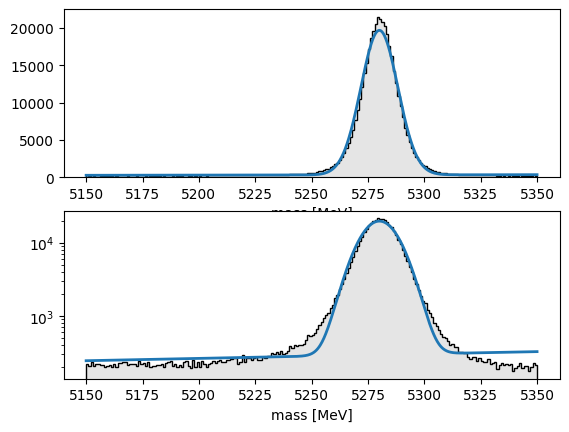

In [37]:
# Import zfit

import zfit
import numpy as np

# temporary hack, to make sure we can rerun this cell as often as we like.
from collections import OrderedDict
zfit.core.parameter.ZfitParameterMixin._existing_params = OrderedDict()

# Specify the mass range. This is need for the fit.
massmin = 5150
massmax = 5350

# Create a zfit data set from the dataframe. There is one thing tricky here:
# when the entries are outside the min/max range, they are
# ommitted when reading the dataframe. To prevent that, we make a selection
# beforehand. We also omit the untagged events (q=0), because we do not have
# much use for them later.
in_mass_range = np.logical_and(df['mass']>massmin,df['mass']<massmax)
tagged = df['qtag']!=0
selection = np.logical_and(in_mass_range,tagged)
# Note that this overwrites the original data frame!
df = df[selection]
massobs = zfit.Space("mass",(massmin,massmax))
zdata = zfit.Data.from_pandas( df, obs = massobs )

# create a zfit pdf for the B0 signal
mu_B0 = zfit.Parameter("mu_B0", 5279, 5250, 5300)
sigma_B0 = zfit.Parameter("sigma_B0", 10, 0, 30)
masspdf_B0 = zfit.pdf.Gauss(mu=mu_B0, sigma=sigma_B0, obs=massobs)

# create a zfit pdf for the exponential background
lambd = zfit.Parameter("lambda", -0.001, -1,+1)
masspdf_bkg = zfit.pdf.Exponential(lambd, obs=massobs)

# create an extended PDF from the sum of these
nev = len( mass )
yield_B0  = zfit.Parameter("yield_B0", 0.9*nev, -0.1*nev, 1.1*nev)
yield_bkg = zfit.Parameter("yield_bkg", 0.1*nev, -0.1*nev, 1.1*nev)
extmasspdf_B0  = masspdf_B0.create_extended(yield_ = yield_B0)
extmasspdf_bkg = masspdf_bkg.create_extended(yield_ = yield_bkg)
pdf_total  = zfit.pdf.SumPDF([extmasspdf_B0, extmasspdf_bkg], name="totPDF")

# create a loss function. this is what we will 'minimize'
nll_data = zfit.loss.ExtendedUnbinnedNLL(model=pdf_total, data=zdata)
# create the minimizer. This one uses minuit, but there are various alternatives.
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_data)
result.hesse()
print(result)

# draw the result
n_bins = 200
mass = df['mass']
plot_scaling = len(mass) / n_bins * massobs.area()
x = np.linspace(massmin,massmax, 1000)
y = pdf_total.pdf(x).numpy()
fig, axes = plt.subplots(2)
axes[1].set_yscale("log")
for i in range(2):
  axis = axes[i]
  color = 'black'
  axis.hist(mass, color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
  axis.hist(mass, color=color, bins=n_bins, histtype="step")
  axis.plot(x, y * plot_scaling, label="Sum - Model", linewidth=2)
  axis.set_xlabel("mass [MeV]")
plt.show()


# Fit with a better mass model

If you look at the final fit result superimposed on the data set, it looks pretty bad. One reason is the 'signal mass model': it is not very well described by a Gaussian. The invariant mass distribution has 'radiative tails' due to QED corrections. Furthermore, the experimental resolution is not very entirely Gaussian.

In LHCb a common solution is to fit with a more complicated model. The most popular solution is the so-called 'double-sided [Crystal Ball](https://en.wikipedia.org/wiki/Crystal_Ball_function)' function. The disadvantage of this model is that it has some highly correlated parameters, which makes the fit a little slow.

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_16, Composed_autoparam_17]] data=[<zfit.core.data.Data object at 0x7abcc81fdf30>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00016 │ 4029.462    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)        hesse    at limit
---------  ------------------  -----------  ----------
yield_B0               411856  +/- 7.2e+02       False
yield_bkg             43838.9  +/- 3.9e+02       False
mu_B0                 5280.15  +/-   0.014       False
sigma_B0              7.36371  +/-   0.021       False
aL_B0                 1.45409  +/-   0.015       False
nL_B0          

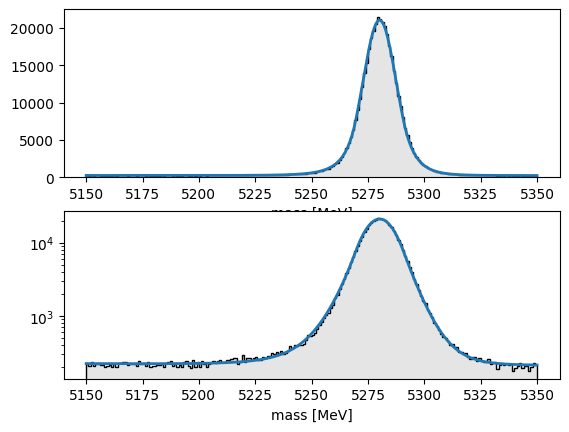

In [38]:
# repeat the fit but with a better mass model. This model is called a
# 'double crystal ball'.
zfit.core.parameter.ZfitParameterMixin._existing_params = OrderedDict()

aL = zfit.Parameter("aL_B0",  1.4, 0.1, 5,floating=True)
aR = aL
nL = zfit.Parameter("nL_B0", 6, 1., 10, floating=True)
nR = zfit.Parameter("nR_B0", 10, 1., 20,floating=True)
masspdf_B0 = zfit.pdf.DoubleCB(obs=massobs, mu=mu_B0, sigma=sigma_B0, alphal=aL, nl=nL, alphar=aR, nr=nR)

extmasspdf_B0  = masspdf_B0.create_extended(yield_ = yield_B0)
extmasspdf_bkg = masspdf_bkg.create_extended(yield_ = yield_bkg)
pdf_total  = zfit.pdf.SumPDF([extmasspdf_B0, extmasspdf_bkg], name="totPDF")

nll_data = zfit.loss.ExtendedUnbinnedNLL(model=pdf_total, data=zdata)
# create the minimizer. This one uses minuit, but there are various alternatives.
result = minimizer.minimize(nll_data)
result.hesse()
print(result)

# draw the result
n_bins = 200
plot_scaling = len(mass) / n_bins * massobs.area()
x = np.linspace(massmin,massmax, 1000)
y = pdf_total.pdf(x).numpy()
fig, axes = plt.subplots(2)
axes[1].set_yscale("log")
for i in range(2):
  axis = axes[i]
  color = 'black'
  axis.hist(mass, color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
  axis.hist(mass, color=color, bins=n_bins, histtype="step")
  axis.plot(x, y * plot_scaling, label="Sum - Model", linewidth=2)
  axis.set_xlabel("mass [MeV]")
plt.show()


# Create the s-weights for background subtraction

To extract the decaytime distribution, we need to subtract the background. We could model the decaytime distribution background and perform a 2D fit to mass and decaytime, but there is an alternative solution that works without a model: Based on the mass fit we can compute so-called s-weights. (See the [sPlot paper](https://arxiv.org/abs/physics/0402083) for details.)  By weighting the events with s-weights, we effectively perform a statistically-optimal background subtraction.

Compute the s-weights using the `hepstats.splot.compute_weights function`. Draw the background subtracted decay time distribution.

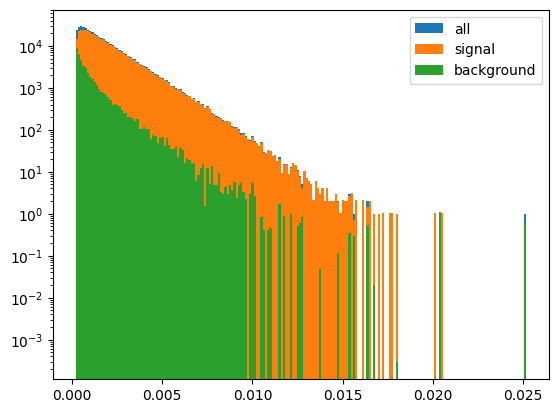

In [39]:
# @ compute s-weights and make a decaytime plot

# use the compute_sweights function from hepstats
from hepstats.splot import compute_sweights
sweights_all = compute_sweights(pdf_total,mass)
sweights_B0 = sweights_all[yield_B0]

# make a background subtracted decay time plot
decaytime = df['decaytime']
plt.hist(decaytime, bins=200, label="all")
plt.hist(decaytime, bins=200,weights = sweights_B0, label="signal")
plt.hist(decaytime, bins=200,weights = 1-sweights_B0, label="background")
plt.yscale("log")
plt.legend()
plt.show()


# Separate mixed and unmixed decays

We will now use the tagging information.lot the decay time distribution separately for the 'mixed' $(q*pid<0)$ and 'unmixed' $(q*pid>0)$ events.

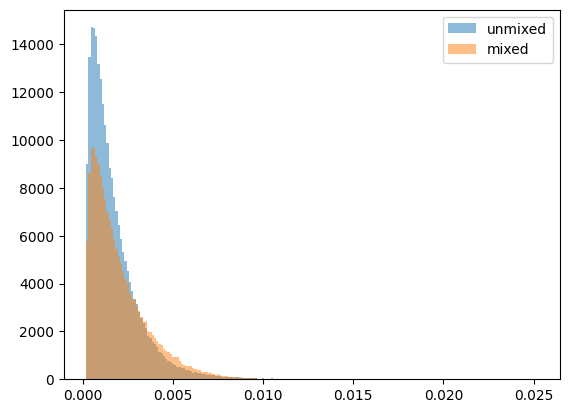

In [41]:
# plot the s-weighted decay time distribution separately for 'mixed' decays
# and for 'unmixed' decays
import matplotlib.pyplot as plt
decaytime = df['decaytime']
q = df["qtag"]
etatag = df["etatag"]
pid = df["pid"]
plt.hist(decaytime, bins=200, weights = sweights_B0 * (pid*q>0), label="unmixed", alpha = 0.5)
plt.hist(decaytime, bins=200, weights = sweights_B0 * (pid*q<0), label="mixed", alpha = 0.5)
plt.legend()
plt.show()


# Draw the binned asymmetry

So observe the oscillation, we now plot the asymmetry in bins of decay time.

To get statistical optimal results, we exploit also the estimated mistag rate, `eta`. The raw asymmetry is given by

$A = \frac{N( \text{unmixed} ) - N(\text{mixed})}{N( \text{unmixed} ) + N(\text{mixed})}$

If we define a 'mixed' variable

$ q = q_\text{prod} q_\text{decay} $

we could compute the asymmetry as

$ A \; = \; \frac{\sum_i w_i q_i}{\sum w_i} $

with $w_i$ the s-weight.

The dilution on the asymmetry due to a constant mistagrate $\eta$, is $D = (1-2\eta)$, which just gives a scale factor for $A$. It turns out (not shown here), that if the dilution is not constant, the dilution-corrected asymmetry is given by

$ A = \frac{\sum_i w_i q_i D_i}{\sum w_i D_i^2} $

where $D_i = 1-2\eta_i$ is the per-event estimated dilution.

Draw the asymmetry in bins of decay time.





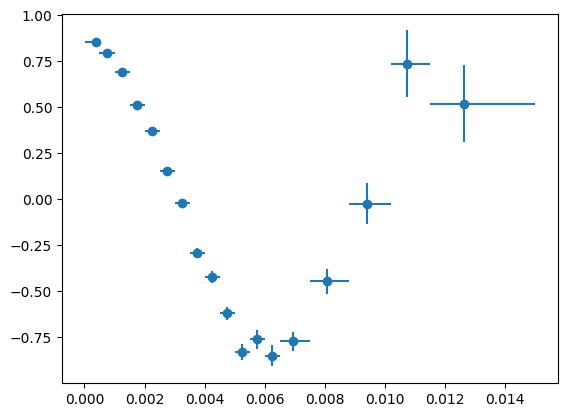

In [42]:

# suggested binning for asymmetry plot
# this is in pico-second
tbins = np.array([0.002,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.5,8.8,10.2,11.5,15.])
# convert to nano-second
tbins = tbins/1000.

# compute the per-event value of q_prod*q_decay*(1-2eta)
qDecay = np.where(pid<0,-1,+1)
qD = q*(1-2*etatag)*qDecay
wqDsum, bin_edges  = np.histogram(decaytime,bins=tbins,weights=sweights_B0*qD)
wqD2sum, bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0*qD*qD)
w2qD2sum, bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0*sweights_B0*qD*qD)
asymmetry    = wqDsum / wqD2sum
asymmetryerr = np.sqrt(w2qD2sum) / wqD2sum

# compute in every bin the average decay time
wtsum, bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0*decaytime)
wsum,  bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0)
avtime = wtsum / wsum

# now draw points with both vertical and horizontal errors
xerrors = [avtime-bin_edges[:-1],bin_edges[1:]-avtime]
plt.errorbar(x=avtime, y=asymmetry, xerr=xerrors, yerr=asymmetryerr,fmt='o')
plt.show()



# Fit the asymmetry

The theoretical model for the mixing asymmetry is

$A = \tfrac{1}{2} \: (1 + \cos(\Delta m\: t))$

However, there is a small experimental problem left: The output of the tagging algorithm is not very well calibrated. Therefore, we need to take into account that the amplitude is wrong by a *dilution scale factor* which we call $f_D$. We will need $f_D$ when we measure $\sin(2\beta)$ tomorrow.

Fit the asymmetry to the model
$A^\text{obs} = \tfrac{f_D}{2} \: (1 + \cos(\Delta m\: t))$

to extract the mixing frequency and the dilution scale factor.

How well does the value of $\Delta m$ agree with the PDG value?


FitResult of
<SimpleLoss model=[] data=[] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.4e-06 │ 21.45081    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
A0                 0.85246  +/-  0.0069       False
DeltaM             506.173  +/-     3.3       False


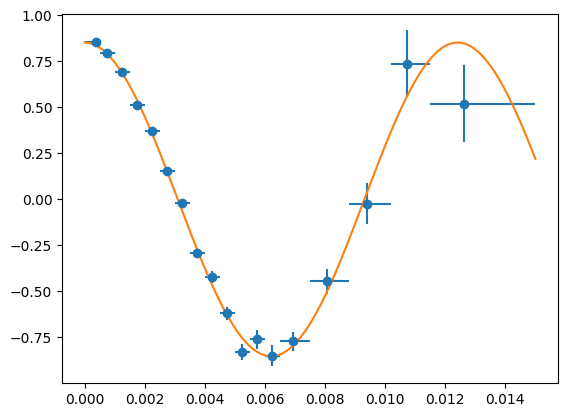

In [43]:
# The code below performs the fit to the binned asymmetry.
# You can also implement an unbinned fit: A solution is written in the solution
# workbook but I didn't yet get it to run on Google Colab.

from tensorflow.python.dlpack.dlpack import from_dlpack
zfit.core.parameter.ZfitParameterMixin._existing_params = OrderedDict()

# declare the parameters
deltaM = zfit.Parameter("DeltaM",500,450,550,floating=True)
A0 = zfit.Parameter("A0",1,0.5,1.5,floating=True)
# define a function that evaluates the chi2 using the asymmetry computed above
def chi2( params ):
  A0 = params[0]
  dm = params[1]
  cosdmt = np.cos(dm * avtime)
  res = A0*cosdmt - asymmetry
  var = np.square(asymmetryerr)
  chi2 = np.sum( np.square(res)/var)
  return chi2
# create a loss function and minimize it
loss = zfit.loss.SimpleLoss(chi2, [A0,deltaM], errordef=1)
result = minimizer.minimize(loss)
result.hesse()
print(result)

# draw the result
plt.errorbar(x=avtime, y=asymmetry, xerr=xerrors, yerr=asymmetryerr,fmt='o')
x = np.linspace(0,0.015, 1000)
y = A0*np.cos(x*deltaM)
plt.plot(x,y)
plt.show()



# Perform an unbinned maximum likelihood fit

Build a PDF and fit it to the unbinned dataset. How do the errors compare to the binned fit?

How does the value of the mixing frequency compare to that in the PDG?

Estimated integral error ( 1.0948651923650355e-05 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increase the 'max_draws' (or adjust 'tol'). If partial integration is chosen, this can lead to large memory consumption.This is a new warning checking the integral accuracy. It may warns too often as it is Work In Progress. If you have any observation on it, please tell us about it: https://github.com/zfit/zfit/issues/new/chooseTo suppress this warning, use zfit.settings.set_verbosity(-1).
Estimated integral error ( 1.0948651923650355e-05 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increas

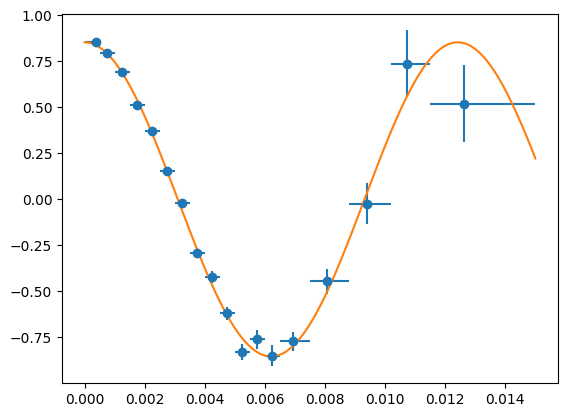

In [45]:
import tensorflow as tf
class BMixingPDF(zfit.pdf.BasePDF):
    """ Generic decay PDF with mixing and CP violation"""
    def __init__(self,obs,A0,deltaM):
        self.A0 = A0
        self.deltaM = deltaM
        paramdict = { x.name : x for x in [A0,deltaM]}
        super().__init__(obs=obs, params=paramdict, name="MixingPDF")
    def _norm(): return 1
    def _unnormalized_pdf(self, x):
      #tf.print(x)
      decaytime, qD = zfit.z.unstack_x(x)
      return (1 +  qD * self.A0 * tf.cos(self.deltaM*decaytime))
    def pdf(self,x,norm=False): return self._unnormalized_pdf(x)

fitobs = zfit.Space("decaytime",(0.,0.015)) * zfit.Space("qD",(-2,2))
if "qD" not in df: df["qD"] = qD
zdata = zfit.Data.from_pandas( df, obs=fitobs, weights=sweights_B0 )

pdf  = BMixingPDF(obs=fitobs,A0=A0,deltaM=deltaM)
nll_data = zfit.loss.UnbinnedNLL(model=pdf, data=zdata)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_data)
result.hesse()
print(result)

# draw the result
plt.errorbar(x=avtime, y=asymmetry, xerr=xerrors, yerr=asymmetryerr,fmt='o')
x = np.linspace(0,0.015, 1000)
y = A0*np.cos(x*deltaM)
plt.plot(x,y)
plt.show()


